In [2]:
import numpy as np
from skimage.segmentation import watershed
from skimage.filters import rank
from skimage.morphology import disk, square, diamond
from skimage.morphology import erosion, dilation, opening, closing

# Setting relative imports in jupyter notebook
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from src import utils
from src import watershed

#%matplotlib tk
import matplotlib.pyplot as plt

### Preparing

First, building the dataframe respective to the dataset content is necessary. This dataframe is composed of general information about the subjects and, in a second moment, the path to the .nii files is added, which are the T1 MRI acquisitions and segmentation masks made by human experts.
The `build_datafram` function has a flag to filter subjects without any segmentation mask. We leave this flag with the default values, i.e., the result dataset only contains subjects with at least one segmentation mask.

In [3]:
# Loading the dataset from the Episurg folder, using the info form subjects.c
df_episurg = utils.build_dataframe('../Episurg', 'subjects.csv')
df_episurg

,Subject,Hemisphere,Type,Preop,Rater1,Rater2,Rater3,t1,seg1,seg2,seg3
1,sub-0002,Right,Temporal lobectomy,False,True,False,False,../Episurg/subjects/sub-0002/postop/sub-0002_p...,../Episurg/subjects/sub-0002/postop/sub-0002_p...,,
10,sub-0011,Left,Temporal lobectomy,False,True,False,True,../Episurg/subjects/sub-0011/postop/sub-0011_p...,../Episurg/subjects/sub-0011/postop/sub-0011_p...,,../Episurg/subjects/sub-0011/postop/sub-0011_p...
17,sub-0018,Right,Frontal lesionectomy,True,True,False,False,../Episurg/subjects/sub-0018/postop/sub-0018_p...,../Episurg/subjects/sub-0018/postop/sub-0018_p...,,
21,sub-0022,Right,Temporal lobectomy,False,True,False,True,../Episurg/subjects/sub-0022/postop/sub-0022_p...,../Episurg/subjects/sub-0022/postop/sub-0022_p...,,../Episurg/subjects/sub-0022/postop/sub-0022_p...
22,sub-0023,Left,Parietal lobectomy,False,True,False,False,../Episurg/subjects/sub-0023/postop/sub-0023_p...,../Episurg/subjects/sub-0023/postop/sub-0023_p...,,
...,...,...,...,...,...,...,...,...,...,...,...
423,sub-0424,Left,Temporal lesionectomy,True,True,False,False,../Episurg/subjects/sub-0424/postop/sub-0424_p...,../Episurg/subjects/sub-0424/postop/sub-0424_p...,,
424,sub-0425,Right,Temporal lobectomy,True,True,False,False,../Episurg/subjects/sub-0425/postop/sub-0425_p...,../Episurg/subjects/sub-0425/postop/sub-0425_p...,,
425,sub-0426,Left,Temporal lesionectomy,True,True,False,False,../Episurg/subjects/sub-0426/postop/sub-0426_p...,../Episurg/subjects/sub-0426/postop/sub-0426_p...,,
427,sub-0428,Right,Temporal lobectomy,False,True,False,False,../Episurg/subjects/sub-0428/postop/sub-0428_p...,../Episurg/subjects/sub-0428/postop/sub-0428_p...,,


### Reading an image

The MRI images can be read with the `utils.get_image` function. This function has as parameters the dataset dataframe (`df_episurg`), the identification code for the subject (ex: sub-0002 can be accessed by passing `0002`), the number of the slice desired, and the perspective of the MRI acquisition (a for axial, c for coronal and s for sagittal)

We use the function `utils.show_nii` to present the MRI image.


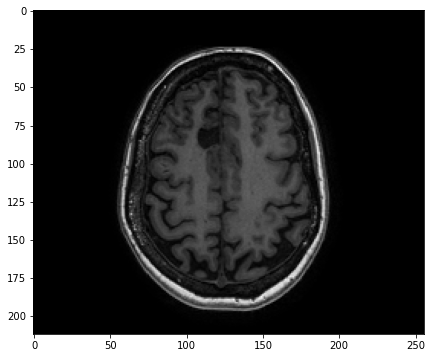

In [4]:
# Loading the MRI image for subject sub-0018, slice 176 from axial perspective
mri_img = utils.get_image(df_episurg, '0018', 176, 'a')
mri_img = np.flip(mri_img)
plt.figure(figsize=(7,7))
utils.show_nii(mri_img)

### Segmentation preprocessing

Before passing the image to the watershed segmentation procedure, some treatment is necessary to improve the success of the segmentation. The `apply_morphology` function receives an image and a set of desired procedures. These procedures include noise reducing and morphological processes. 

Let us iniatilly only apply a noise reduction by median filter and view the result. A structural element (SE key) of type Disk with size three is applied for this filter.

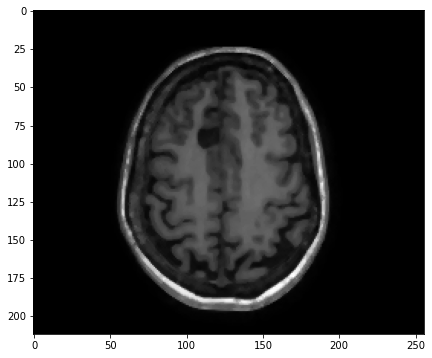

In [5]:
# For the morphology procedures is first necessary normalize the image
mri_norm = utils.normalize_img(mri_img)
mri_denoised = watershed.apply_morphology(mri_norm,
                                          denoise_1={'method': rank.median, 'se': disk(2)},
                                          )
plt.figure(figsize=(7,7))
utils.show_nii(mri_denoised)

### Performing the segmentation

To perform the assisted segmentation, the expert must select the region of interest. We simulated that operation by manually setting a pixel in the source image (`mri_denoised`). In this example, the selected pixel was the x = 116  and y = 85. Let us mark this pixel in the `mri_denoised_mark` image for visualization purposes only (that image is not really used for segmenting).

We also mark a pixel anywhere in the area inside the brain but outside of the region of interest.

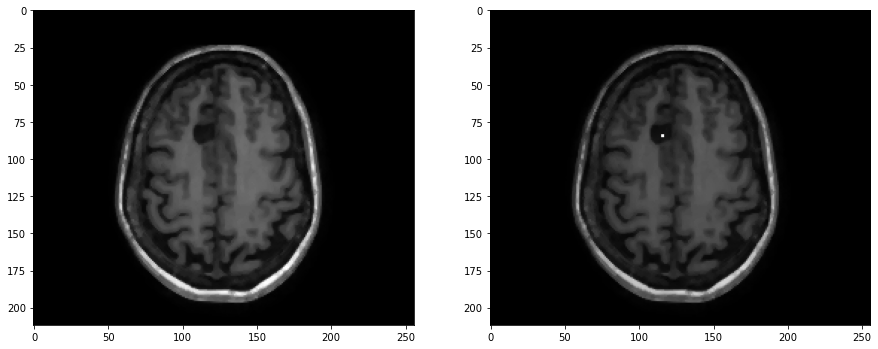

In [6]:
# Setting the pixels values
x = 116
y = 85
# Pixel in inside the brain but not in the region of interest
outer_mark_x = 109
outer_mark_y = 99
# This mask array contains the pixels values which will be seeds do the watershed segmentation
mask = [[x, y], [outer_mark_x, outer_mark_y]]

# Making a dummy copy of mri_denoised and marking the pixel region for visualization purpose only
mri_denoised_marked = mri_denoised.copy()
# Setting a little region around the pixel to easy the identification in the image 
mri_denoised_marked[-1 + y:1+y, -1 + x:1 + x] = 255

# Plotting the images side by side to easy the detection of the marked pixel
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(mri_denoised, cmap='gray')
plt.subplot(122)
plt.imshow(mri_denoised_marked, cmap='gray')
plt.show()

Finally, we apply the watershed method, inputting the MRI denoised image and the mask with the two seed pixels. Internally in the `apply_watershed` function, another pixel is marked as a seed, that one entirely outside the brain, in the "true" background, which is the pixel in position (0, 0)

In [7]:
img_seg = watershed.apply_watershed(mri_denoised, mask)

### Preliminary results

Here we can visualize the result segmentation. As observed, the segmentation was not well succeeded, with the region of interest not being segmented. We have three labels as a result: 
- Label 1 (purple): Outside the brain (actual background of the MRI volume)
- Label 2 (blue): The region of interest
- Label 3 (yellow): The region inside the brain but not of interest

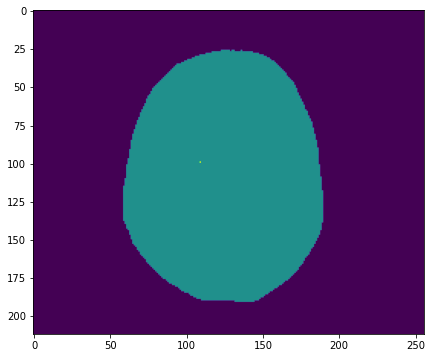

In [8]:
plt.figure(figsize=(7,7))
plt.imshow(img_seg)


In this turn, we explore including a gradient procedure in the processing pipeline. Due to the watershed segmentation relation with topological concepts, are applied gradients as preprocessing to gather local minima. On the first try, we only applied a denoise median filter in the image before proceeding with the segmentation.

We apply a gradient with a disk structural element of size 1

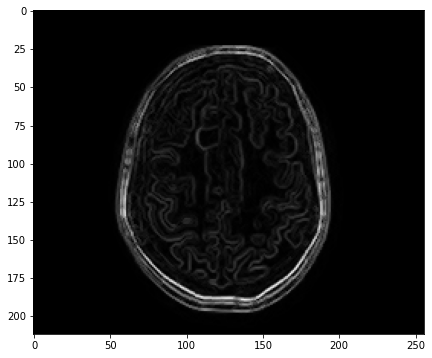

In [9]:

mri_denoised = watershed.apply_morphology(mri_norm,
                                          denoise_1={'method': rank.median, 'se': disk(2)},
                                          gradient_1={'method': rank.gradient, 'se': disk(1)},
                                          )
plt.figure(figsize=(7,7))
utils.show_nii(mri_denoised)

Once again, we define the pixel seeds and plot the on-purpose exaggerated location of the region of interest seed for visualization.

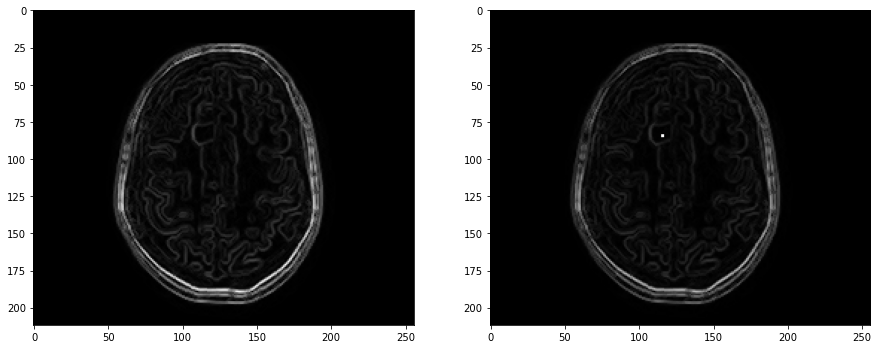

In [10]:
# Setting the pixels values

x = 116
y = 85
outer_mark_x = 109
outer_mark_y = 99
# This mask array contains the pixels values which will be seeds do the watershed segmentation
mask = [[x, y], [outer_mark_x, outer_mark_y]]

# Making a dummy copy of mri_denoised and marking the pixel region for visualization purpose only
mri_denoised_marked = mri_denoised.copy()
# Setting a little region around the pixel to easy the identification in the image 
mri_denoised_marked[-1 + y:1+y, -1 + x:1 + x] = 255

# Plotting the images side by side to easy the detection of the marked pixel
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(mri_denoised, cmap='gray')
plt.subplot(122)
plt.imshow(mri_denoised_marked, cmap='gray')
plt.show()
#utils.show_nii(mri_denoised)

And once again, apply the watershed segmentation

In [11]:
img_seg = watershed.apply_watershed(mri_denoised, mask)

We can observe that the segmentation was well succeeded in this run. The blue region, i.e., the segment related to the region of interest, is well-shaped and precise. 

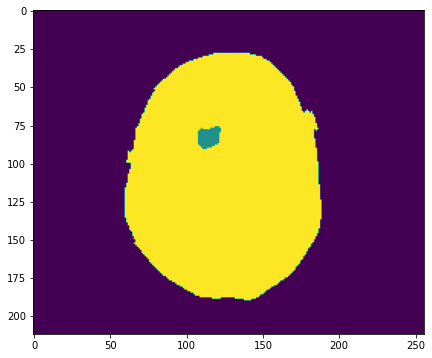

In [12]:
plt.figure(figsize=(7,7))
plt.imshow(img_seg)
plt.show()

Let us plot the MRI image overlayed by the segmentation mask to visualize the result

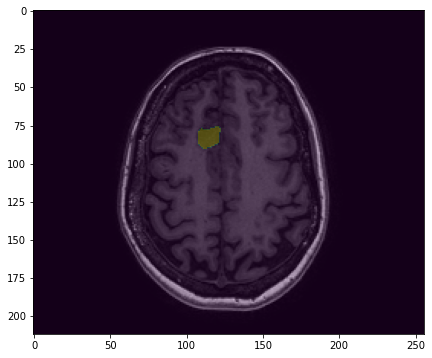

In [13]:
plt.figure(figsize=(7,7))
plt.imshow(mri_norm, cmap='gray')
# Setting all the other labels to zero and leaving one the label for the region of interest
img_seg[img_seg != 2] = 0
plt.imshow(img_seg, alpha=0.3)
plt.show()

We can also view the ground-truth segmentation provided by a human expert

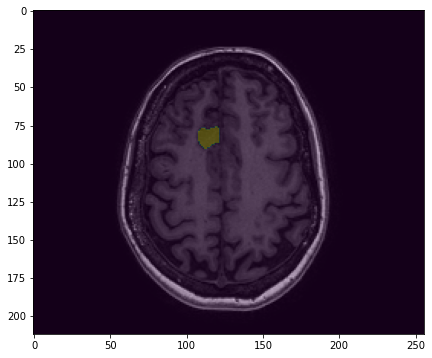

In [14]:
# Getting the groundtruth mask segmentation of the subject
mask_groundtruth = utils.get_image(df_episurg, '0018', 176, 'a', True)
# Correcting the orientation to visualize
mask_groundtruth = np.flip(mask_groundtruth)
plt.figure(figsize=(7,7))
plt.imshow(mri_norm, cmap='gray')
plt.imshow(mask_groundtruth, alpha=0.3)
plt.show()

Comparing the MRI image with the segmentations masks side-by-side, with the ground-truth mask in the middle panel and the watershed segmentation in the right panel

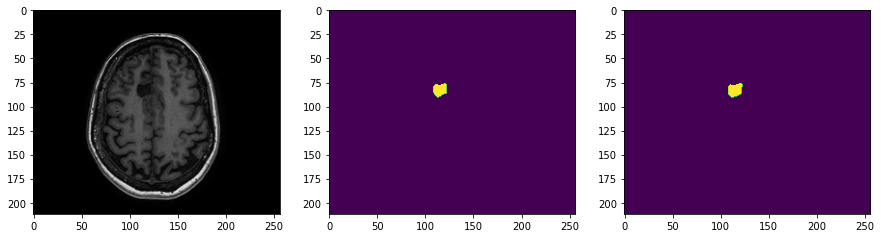

In [15]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(mri_norm, cmap='gray')
plt.subplot(132)
plt.imshow(mask_groundtruth)
plt.subplot(133)
plt.imshow(img_seg)
plt.show()

Finally, comparing both ground-truth mask and watershed segmentation side-by-side while overlaying the MRI image

- Left: The MRI image with ground-truth mask
- Right: The MRI image with the watershed segmented mask

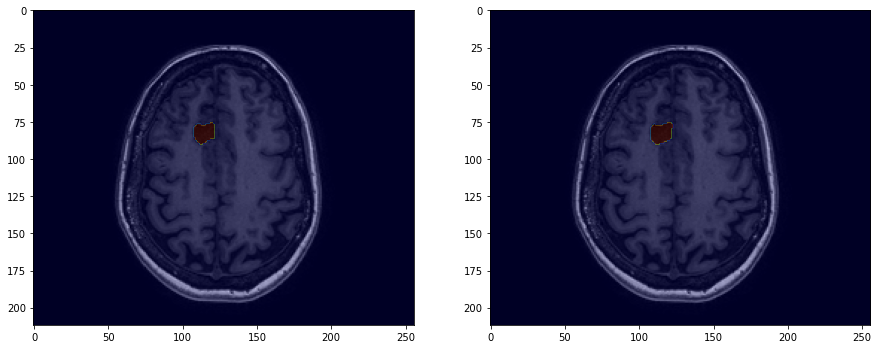

In [16]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(mri_norm, cmap='gray')
plt.imshow(mask_groundtruth, cmap='jet', alpha=0.3)
plt.subplot(122)
plt.imshow(mri_norm, cmap='gray')
img_seg[img_seg < 2] = 0
img_seg[img_seg > 2] = 0
plt.imshow(img_seg, cmap='jet', alpha=0.3)
plt.show()

### Conclusion

The preliminary experiments showed that a composition of procedures was necessary to reach satisfactory results when using the watershed method. The combination of noise reduction with gradient filter succeeded in segmenting a small region of interest, resulting in a segment almost identical to the ground-truth human mask. However, more investigation is necessary to expand this conclusion to more challenging regions with more open borders and complex shapes.